## Question
ABC grocery store opened a store in January 2018. The store has been running for two years and they want to make a business decision based on the returns they've been getting from this store. What is the sales trend at this store over time? Should they keep investing in this store? Would it make more sense to move their business to another location? The analysis in this notebook attempts to provide answers to these questions.

In [1]:
#Import required packages

import pandas as pd
import numpy as np
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_plotly
import plotly.offline as py
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
#Import dataset

abc_sales = pd.read_csv("D:/DataScience/personal/Python/ABC_Groceries_Sales.csv", parse_dates=[0])

## Exploratory Data Analysis

In [3]:
#Take a peek at the data

print('-'*30)
print('  ### Head of Dataset ###')
print('_'*30)
print(abc_sales.head())
print('-'*30)
print('  ### Tail of Dataset ###')
print('_'*30)
print(abc_sales.tail())
    

------------------------------
  ### Head of Dataset ###
______________________________
        Date    Sales
0 2018-02-01  21199.0
1 2018-02-02  10634.0
2 2018-02-03   7966.0
3 2018-02-04   1353.0
4 2018-02-05   9497.0
------------------------------
  ### Tail of Dataset ###
______________________________
          Date    Sales
751 2020-02-22  18723.1
752 2020-02-23   4274.9
753 2020-02-24  45805.7
754 2020-02-25  35566.3
755 2020-02-26  46703.0


In [4]:
abc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
Date     756 non-null datetime64[ns]
Sales    756 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.9 KB


In [5]:
#Rename dataset features (Required for prophet)

abc_sales.columns = ['ds','y']
print(abc_sales.head())
print('\nDataset shape: ',abc_sales.shape)

          ds        y
0 2018-02-01  21199.0
1 2018-02-02  10634.0
2 2018-02-03   7966.0
3 2018-02-04   1353.0
4 2018-02-05   9497.0

Dataset shape:  (756, 2)


In [6]:
#Set custom plotting style

plt.style.use('seaborn-bright')

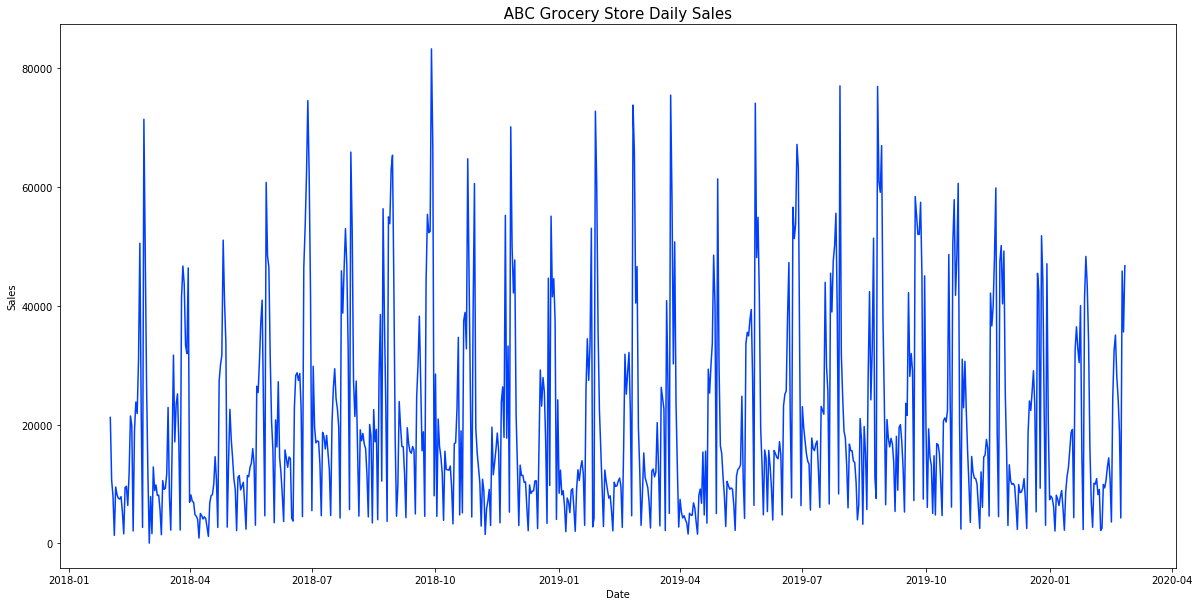

In [7]:
## Plot the Time series data

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="ds", y="y", data=abc_sales)
ax.set(xlabel='Date', ylabel='Sales')
ax.set_title(" ABC Grocery Store Daily Sales ",fontsize=15)
plt.show()

From the plot we see that the store experience a quick and dramtic increase in sales within the first three months of opening. These sales number fluctuacte in between, but seem to follow a constant trend, frequently hitting peaks as high as $80000. However, around late December 2019, the peaks start to drop. Maybe this is just a blip, or maybe it is new trend. I guess we will find out soon enough.
We will try to break the data into periodic subsets to get a deeper understanding of the Sales trends change.

In [8]:
#Understand periodic sales trends

def date_periods(df, label=None):
    df = df.copy()

    df['date'] = df.ds
    df['month'] = df['ds'].dt.strftime('%B')
    df['year'] = df['ds'].dt.strftime('%Y')
    df['dayofweek'] = df['ds'].dt.strftime('%A')
    df['quarter'] = df['ds'].dt.quarter
        
    X = df[['dayofweek','month','quarter','year']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
X, y = date_periods(abc_sales, label='y')
periodic_df = pd.concat([X, y], axis=1)
periodic_df.head(7)

dayofweek     month  quarter  year        y
0   Thursday  February        1  2018  21199.0
1     Friday  February        1  2018  10634.0
2   Saturday  February        1  2018   7966.0
3     Sunday  February        1  2018   1353.0
4     Monday  February        1  2018   9497.0
5    Tuesday  February        1  2018   8207.0
6  Wednesday  February        1  2018   7581.0

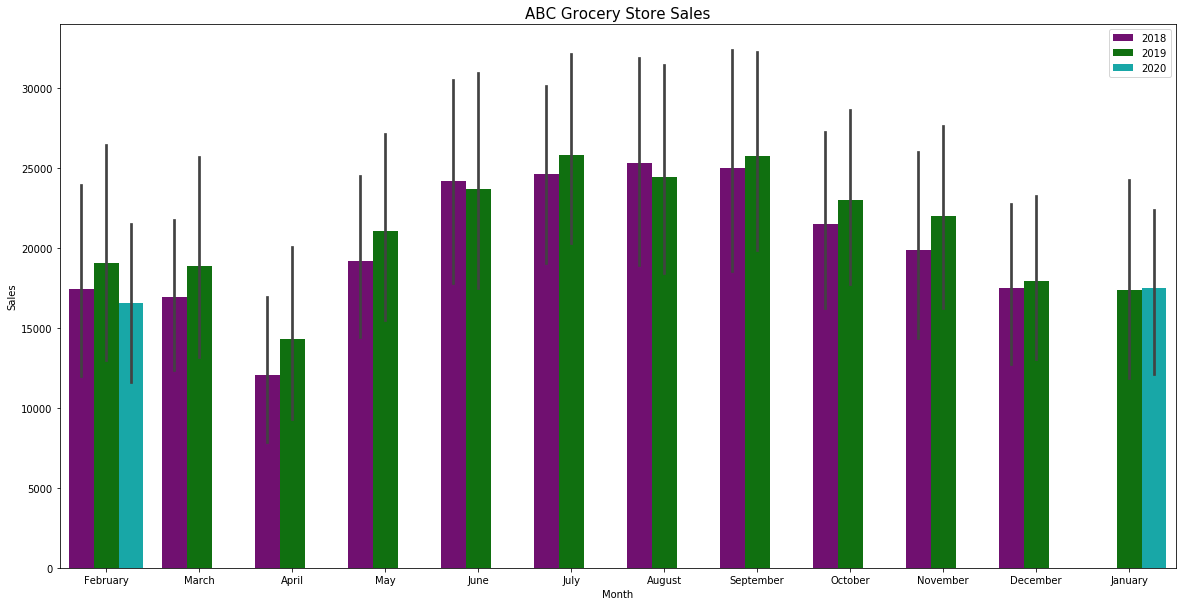

In [10]:
#Plotting periodic features to understand trend

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="month", y="y",hue = 'year',palette = ['purple','g','c','black'],data=periodic_df)
ax.set(xlabel='Month', ylabel='Sales')
ax.set_title("ABC Grocery Store Sales",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Looks like ABC makes the most money from this store between June and September. I wonder why. Maybe because it's the summer and people go out more? Question for another day.  
Let's take a step further and explore even deeper trends.

Text(0.5, 1.0, 'Total Sales received By year')

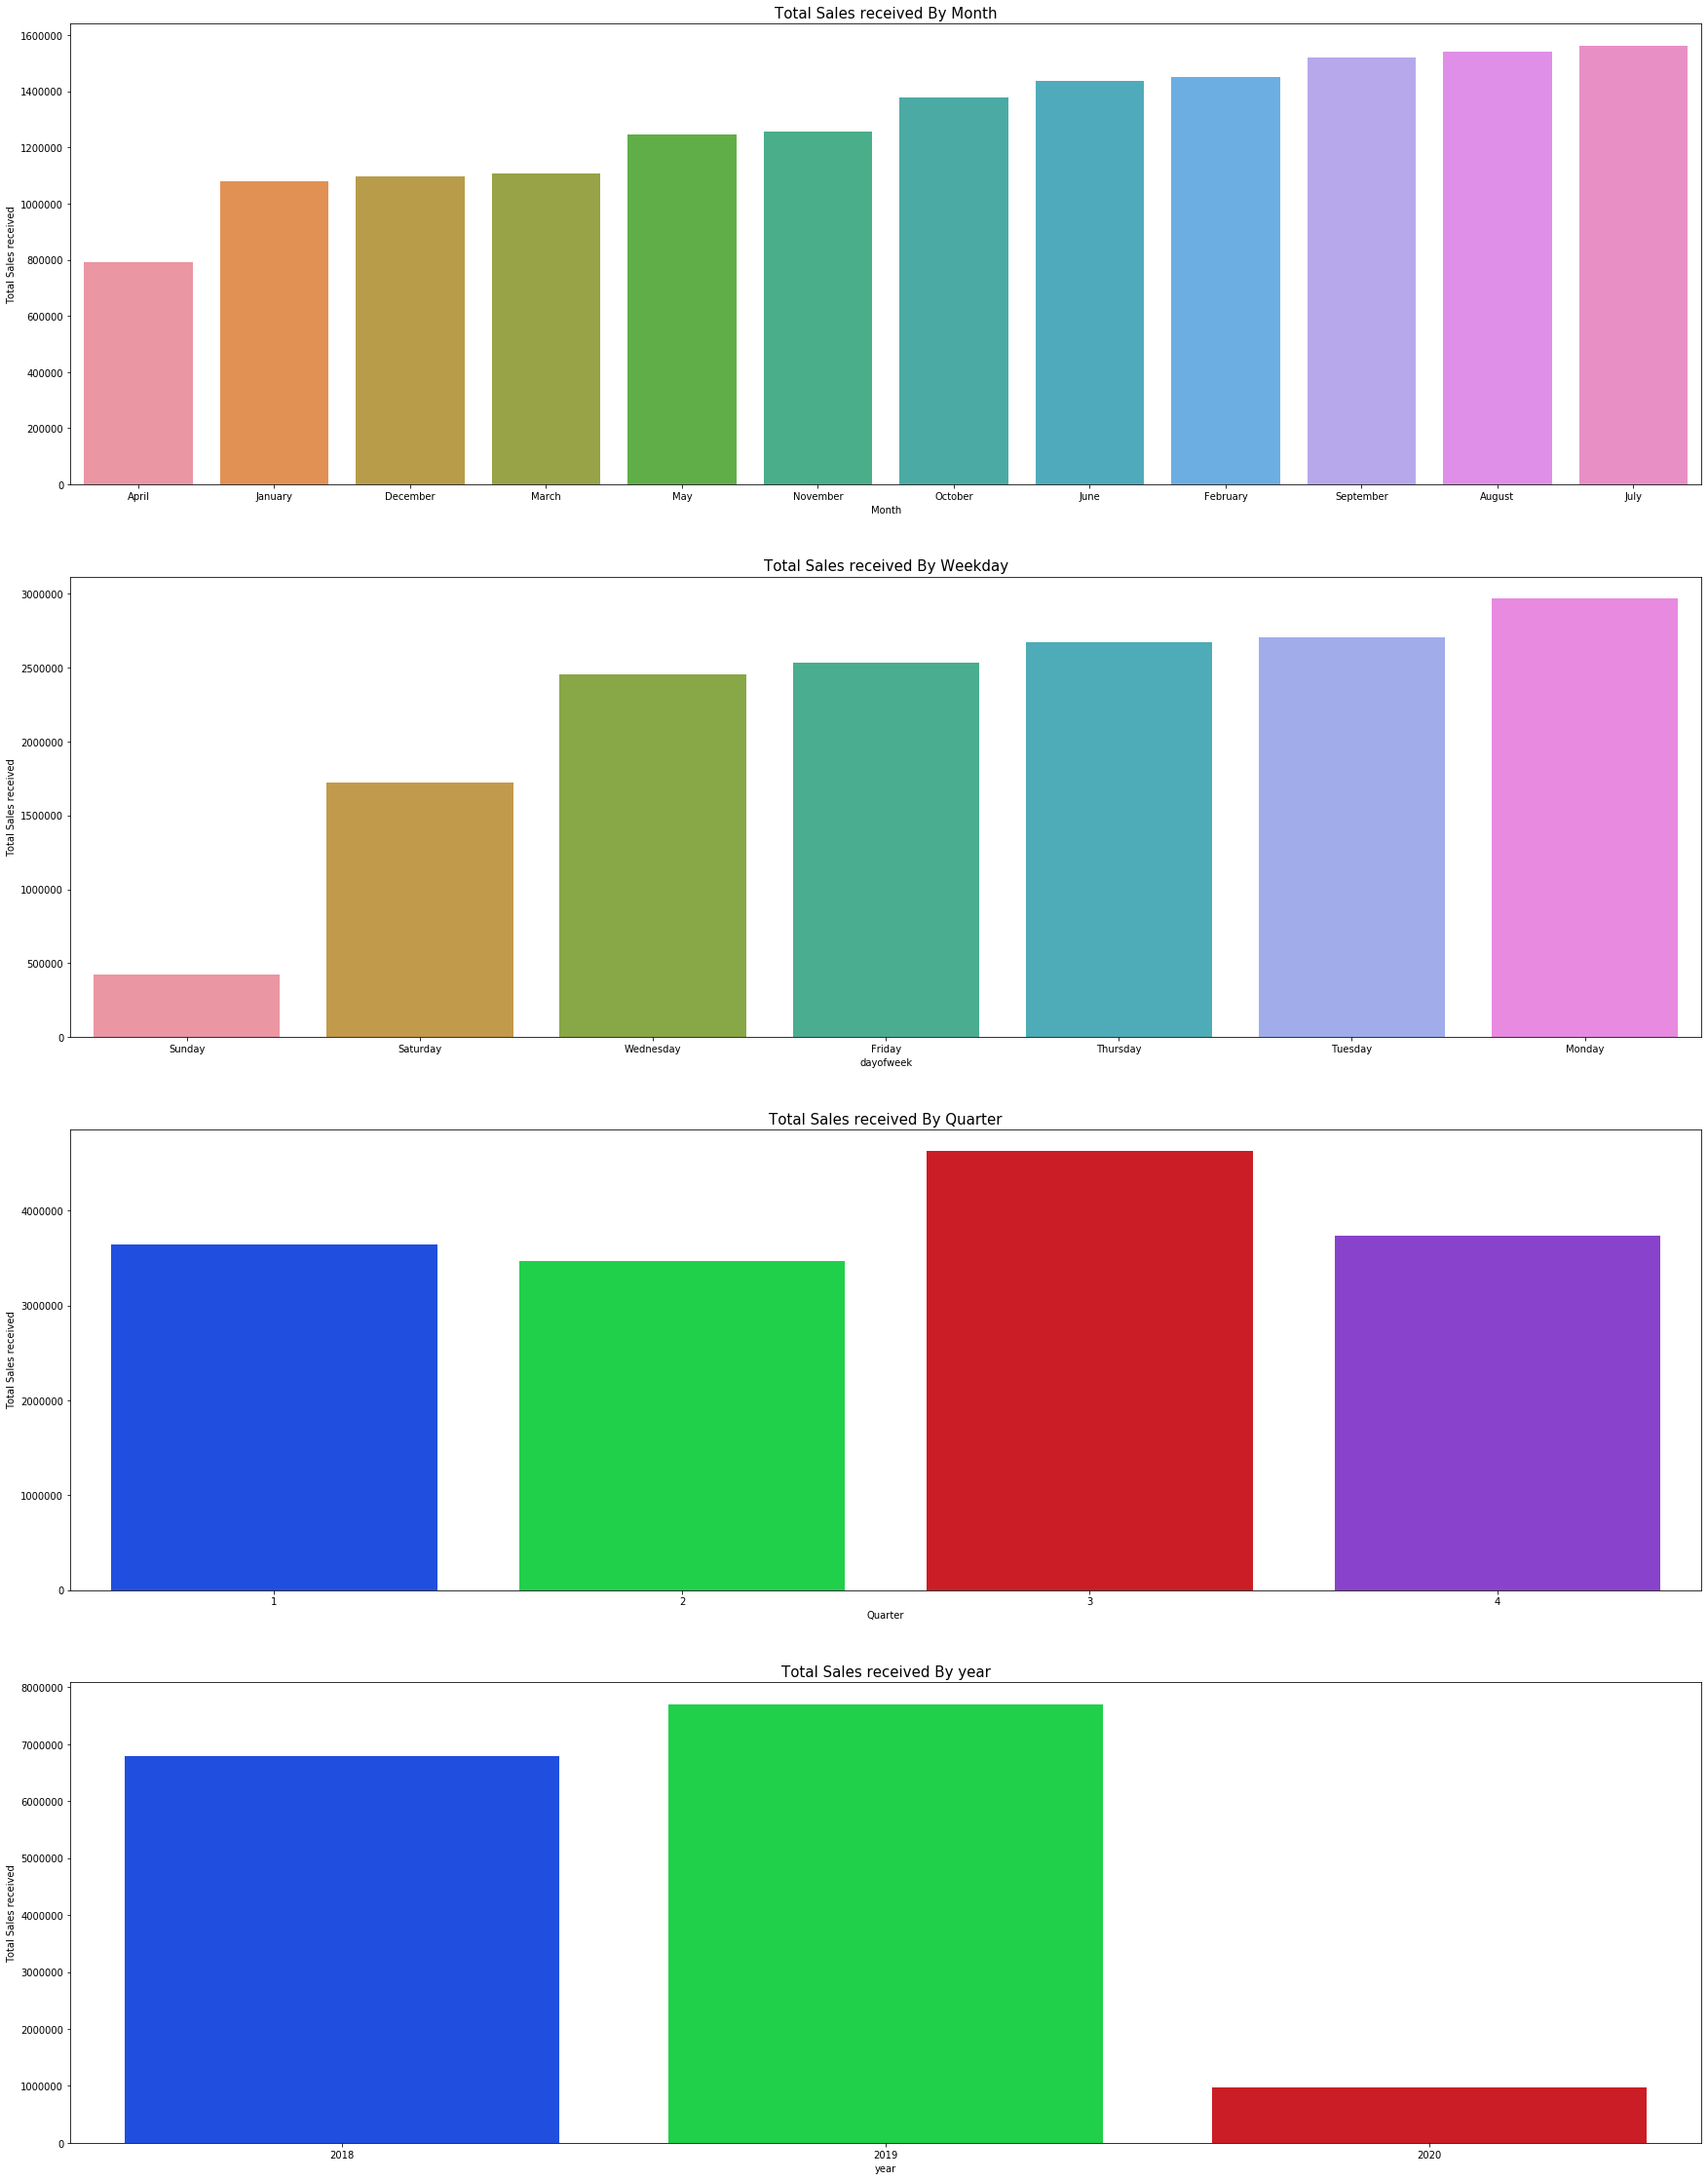

In [11]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(30,40)

monthTotals = pd.DataFrame(periodic_df.groupby("month")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthTotals,x="month",y="y",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales received')
ax1.set_title("Total Sales received By Month",fontsize=15)

monthTotals = pd.DataFrame(periodic_df.groupby("dayofweek")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthTotals,x="dayofweek",y="y",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total Sales received')
ax2.set_title("Total Sales received By Weekday",fontsize=15)

monthTotals = pd.DataFrame(periodic_df.groupby("quarter")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthTotals,x="quarter",y="y",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total Sales received')
ax3.set_title("Total Sales received By Quarter",fontsize=15)

monthTotals = pd.DataFrame(periodic_df.groupby("year")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthTotals,x="year",y="y",ax=ax4)
ax4.set(xlabel='year', ylabel='Total Sales received')
ax4.set_title("Total Sales received By year",fontsize=15)

So this grocery store makes more money during the week than on weekend. Interesting. I always thought that grocery stores would be busier on weekends because that's when a lot of people have time to shop but I guess not. Also the store makes the most money during the third quarter which is similar to what we saw previously.

## Data Preparation and Modeling

Because of the rather small size of the dataset, I decided that we will train with one year of data (2018), and test with the next year (2019). That way we can be sure that our model is good enough to produce a great sales forecast for at least a year. We will then use this model to forecast sales for 2020.

In [12]:
#split train/test data 

end_date1 = '2018-12-31'
end_date2 = '2019-12-31'
X_train = abc_sales.loc[(abc_sales['ds'] <= end_date1)]
X_test = abc_sales.loc[(abc_sales['ds'] > end_date1) & (abc_sales['ds'] <= end_date2)]
print("train shape",X_train.shape)
print("test shape",X_test.shape)

train shape (334, 2)
test shape (365, 2)


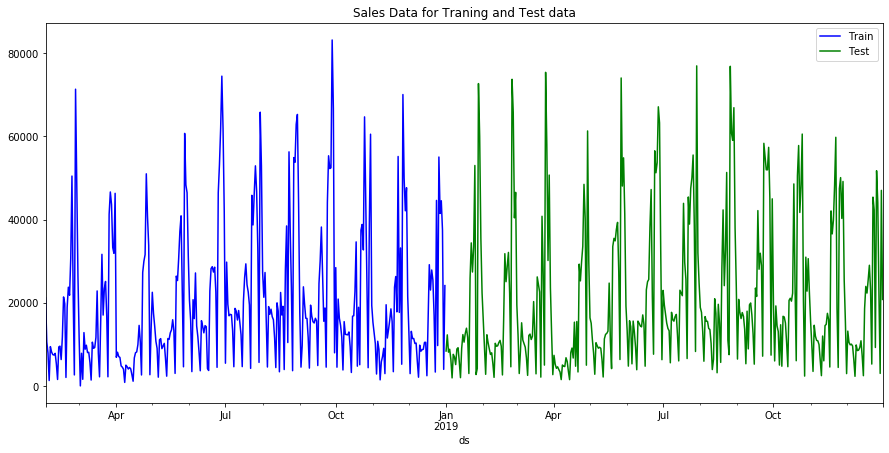

In [13]:
#Plotting train and test

#Use matplotlib plotting instead of pandas by registering matplotlib converters
pd.plotting.register_matplotlib_converters()

f, ax = plt.subplots(figsize=(15,7))
X_train.plot(x='ds', y='y', color='blue', label='Train', ax=ax)
X_test.plot(x='ds', y='y', color='green', label='Test', ax=ax)
plt.title('Sales Data for Traning and Test data')
plt.show()

We will build a base model and then apply different techniques to improve on it.

In [14]:
#Base prophet model

model = Prophet()
model.fit(X_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future = model.make_future_dataframe(periods = 365, freq = 'D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','weekly','weekly_lower','weekly_upper']].tail(10)

ds          yhat    yhat_lower    yhat_upper        weekly  \
689 2019-12-22  15010.125944  -3099.947524  34411.928737 -16825.226931   
690 2019-12-23  37214.370299  18391.590418  56780.995395   5357.592704   
691 2019-12-24  36347.075261  19594.934951  55359.350325   4468.872945   
692 2019-12-25  34480.233459  16125.117689  53848.259571   2580.606422   
693 2019-12-26  37226.225581  19406.846466  56543.568050   5305.173823   
694 2019-12-27  34085.642142  15264.631500  53091.394296   2143.165663   
695 2019-12-28  28933.716575   8778.108363  46519.619032  -3030.184625   
696 2019-12-29  15160.098989  -3747.853983  33705.987976 -16825.226931   
697 2019-12-30  37364.343345  19246.863816  55633.187072   5357.592704   
698 2019-12-31  36497.048307  18356.961985  54790.851436   4468.872945   

     weekly_lower  weekly_upper  
689 -16825.226931 -16825.226931  
690   5357.592704   5357.592704  
691   4468.872945   4468.872945  
692   2580.606422   2580.606422  
693   5305.173823   5305.173823  
694   2143.165663   2143.165663  
695  -3030.184625  -3030.184625  
696 -16825.226931 -16825.226931  
697   5357.592704   5357.592704  
698   4468.872945   4468.872945

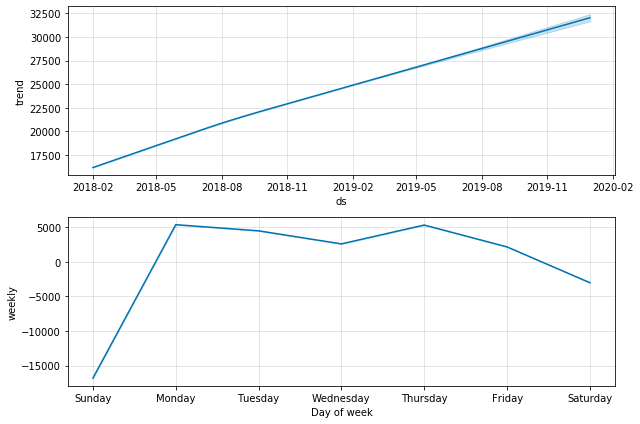

In [16]:
#plot model components

fig = model.plot_components(forecast)

This model suggests a trend of continues linear increase in sales from year to year. We already know this is not accurate because we say that around october of 2019, the sales trend starts to decrease significantly.  
Let's make an interactive plot to better explore and disect the forecast.

In [17]:
#Use interactive plot to better understand forecast

py.init_notebook_mode()

In [18]:
py.iplot(plot_plotly(model, forecast))

In [19]:
#Comapre Actuals vs Predictions 

X_test_forecast = model.predict(X_test)
X_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','weekly','weekly_lower','weekly_upper']].tail(10)

ds          yhat    yhat_lower    yhat_upper        weekly  \
355 2019-12-22  15010.125944  -3412.649752  33168.497966 -16825.226931   
356 2019-12-23  37214.370299  18462.657317  55632.048206   5357.592704   
357 2019-12-24  36347.075261  16953.579246  55166.940832   4468.872945   
358 2019-12-25  34480.233459  16581.938202  53736.722679   2580.606422   
359 2019-12-26  37226.225581  18547.031374  54165.425253   5305.173823   
360 2019-12-27  34085.642142  14426.949041  53153.860877   2143.165663   
361 2019-12-28  28933.716575  10220.968469  48037.842696  -3030.184625   
362 2019-12-29  15160.098989  -4675.179228  34894.510732 -16825.226931   
363 2019-12-30  37364.343345  18712.266656  56915.257410   5357.592704   
364 2019-12-31  36497.048307  16808.867390  55132.033087   4468.872945   

     weekly_lower  weekly_upper  
355 -16825.226931 -16825.226931  
356   5357.592704   5357.592704  
357   4468.872945   4468.872945  
358   2580.606422   2580.606422  
359   5305.173823   5305.173823  
360   2143.165663   2143.165663  
361  -3030.184625  -3030.184625  
362 -16825.226931 -16825.226931  
363   5357.592704   5357.592704  
364   4468.872945   4468.872945

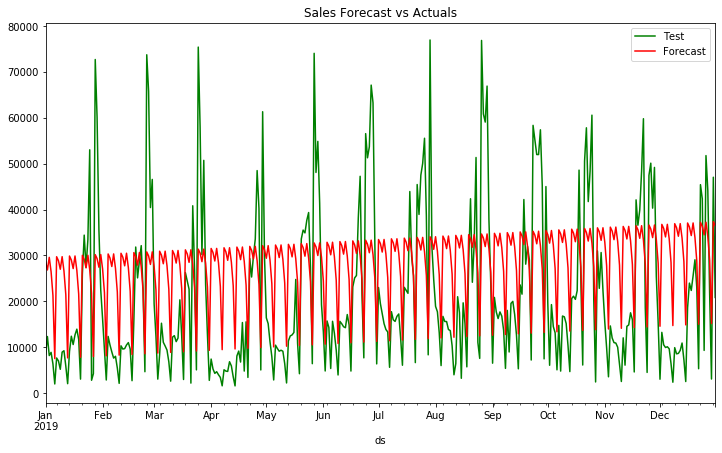

In [20]:
#Compare test sales to forecasted sales

f, ax = plt.subplots(figsize=(12,7))
X_test.plot(kind='line',x='ds', y='y', color='green', label='Test', ax=ax)
X_test_forecast.plot(kind='line',x='ds',y='yhat', color='red',label='Forecast', ax=ax)
plt.title('Sales Forecast vs Actuals')
plt.show()

Clearly the base model is very basic and it isn't robust or flexible enough to track the seasonal changes in the sales. We are going to improve on this module, using `Mean Absolute Percent Error`(MAPE) as our metric for measuring performance.

In [21]:
#Function to calculate mean absolute percent error

def m_a_p_e(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mape = m_a_p_e(X_test['y'], X_test_forecast['yhat'])
print('MAPE:', round(mape,5))

MAPE: 139.55471


This score is not surprising considering how poorly the model performed.  
We are going to try and optimize this model by using hyperparameter tuning. Some of these hyperparameters include:  
* `holidays` which is used to add the effects of holidays to the model. For example adding the effect of NBA play-offs when trying to model ticket sales. Custom holidays can be made and added to the dataframe, or built-in holidays for a given country can be used. We will be using the built-in **US** holidays for this model.
* `n_changepoints` which is how often changes happen in the data. Prophet model detects them by its own. By default, its value is 25, which are uniformly placed in the first 80% of the time series. Changing n_changepoints can add value to the model.

* `changepoint_prior_scale` which is used to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If you make it high it will be more flexible, but you can end up overfitting. By default, this parameter is set to 0.05

* `seasonality_mode` which could be one of two modes: additive & multiplicaticative. By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. Prophet can model multiplicative seasonality by setting seasonality_mode='multiplicative' in the model. We will be using **additive** mode because the seasonality in this data is pretty much even throughout the time series.

* `holiday_prior_scale` which is used to smoothen the effect of holidays, similar to changepoint_prior_scale. By default it has a value of 10, which provides very little regularization. Reducing this parameter dampens holiday effects.

* `Seasonalities with fourier_order` Prophet model, by default finds the seasonalities and adds the default parameters of the seasonality. We can modify the seasonalities effect by adding custom seasonalities using **add_seasonality** in the model with different fourier_order values.By default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

Considering the small size of the dataset, we will use sklearn's `ParameterGrid` to generate a bunch of different possible models, and pick the best one to use for prediction. While this may seem like a brute force approach, I thought it was logical to use it in this situation anyways.

In [23]:
#Optimize prophecy using other hypertuning parameters

from sklearn.model_selection import ParameterGrid

params = {'changepoint_prior_scale':[0.1,0.3,0.5],
          'holidays_prior_scale':[0.1,0.3,0.5],
          'n_changepoints' : [100,150,200],
          'y_fourier_order': [10,15,20],
          'm_fourier_order': [5,10,15],
          'w_fourier_order': [5,10],
          'd_fourier_order': [1,3]}
grid = ParameterGrid(params)
count = 0
for p in grid:
    count = count+1

print('Total Possible Models:',count)

Total Possible Models: 972


In [24]:
import random

In [27]:
#Evaluate performance of all possible models

start='2018-12-31'
end='2019-12-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])

for p in grid:
    test = pd.DataFrame()
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = 'additive',
                         weekly_seasonality=p['w_fourier_order'],
                         daily_seasonality = p['d_fourier_order'],
                         yearly_seasonality = p['y_fourier_order'],
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.add_seasonality(name='monthly', period=30.5, fourier_order=p['m_fourier_order'])
    train_model.fit(X_train)
    train_forecast = train_model.make_future_dataframe(periods=365, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = abc_sales[(abc_sales['ds']>start) & (abc_sales['ds']<=end)]
    MAPE = m_a_p_e(Actual['y'],abs(test['yhat']))
    
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
    l = len(model_parameters)
    #Print every 100th hyperparameter list and MAPE
    if l==1 or l%100 == 0:
        print(p)
        print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    

{'changepoint_prior_scale': 0.1, 'd_fourier_order': 1, 'holidays_prior_scale': 0.1, 'm_fourier_order': 5, 'n_changepoints': 100, 'w_fourier_order': 5, 'y_fourier_order': 10}
Mean Absolute Percentage Error(MAPE)------------------------------------ 76.45867778850378
{'changepoint_prior_scale': 0.1, 'd_fourier_order': 1, 'holidays_prior_scale': 0.3, 'm_fourier_order': 15, 'n_changepoints': 150, 'w_fourier_order': 10, 'y_fourier_order': 10}
Mean Absolute Percentage Error(MAPE)------------------------------------ 76.67613976316775
{'changepoint_prior_scale': 0.1, 'd_fourier_order': 3, 'holidays_prior_scale': 0.1, 'm_fourier_order': 15, 'n_changepoints': 100, 'w_fourier_order': 5, 'y_fourier_order': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 74.74853666251512
{'changepoint_prior_scale': 0.1, 'd_fourier_order': 3, 'holidays_prior_scale': 0.5, 'm_fourier_order': 10, 'n_changepoints': 150, 'w_fourier_order': 10, 'y_fourier_order': 20}
Mean Absolute Percentage E

In [28]:
#Sort parameters by best performance

parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

MAPE                                         Parameters
0  72.879941  {'changepoint_prior_scale': 0.5, 'd_fourier_or...
1  72.899028  {'changepoint_prior_scale': 0.5, 'd_fourier_or...
2  72.923166  {'changepoint_prior_scale': 0.5, 'd_fourier_or...
3  72.962356  {'changepoint_prior_scale': 0.5, 'd_fourier_or...
4  72.977681  {'changepoint_prior_scale': 0.5, 'd_fourier_or...

In [29]:
#Use best parameters to predict
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.5,
 'd_fourier_order': 1,
 'holidays_prior_scale': 0.3,
 'm_fourier_order': 10,
 'n_changepoints': 150,
 'w_fourier_order': 10,
 'y_fourier_order': 10}

Now that we have our best hyperparameters, let us go ahead and use them to train the first two years of data. Recall that we have two years of data (2018 and 2019), and two months of data for 2020. We will train on the first two years, and test with the 2020 data.

In [30]:
#train best model on 2018 and 2019 data

final_train = abc_sales[abc_sales['ds'] <= end]
final_test = abc_sales[abc_sales['ds'] > end]

print('-'*30)
print('  ### Tail of train dataset ###')
print('_'*30)
print(final_train.tail(10))
print('-'*30)
print('  ### Tail of test dataset ###')
print('_'*30)
print(final_test.tail(10))


------------------------------
  ### Tail of train dataset ###
______________________________
            ds        y
689 2019-12-22   5304.6
690 2019-12-23  45420.6
691 2019-12-24  42336.8
692 2019-12-25   9293.7
693 2019-12-26  51757.3
694 2019-12-27  44154.6
695 2019-12-28  21527.6
696 2019-12-29   3058.5
697 2019-12-30  47041.5
698 2019-12-31  20839.1
------------------------------
  ### Tail of test dataset ###
______________________________
            ds        y
746 2020-02-17  24425.7
747 2020-02-18  32450.5
748 2020-02-19  35041.9
749 2020-02-20  28088.8
750 2020-02-21  24412.5
751 2020-02-22  18723.1
752 2020-02-23   4274.9
753 2020-02-24  45805.7
754 2020-02-25  35566.3
755 2020-02-26  46703.0


In [31]:
#Build final model with best hyperparameters

final_model = Prophet(changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 150,
                      seasonality_mode = 'additive',
                      weekly_seasonality=10,
                      daily_seasonality = 3,
                      yearly_seasonality = 10,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.add_seasonality(name='monthly', period=30.5, fourier_order=10)
final_model.fit(final_train)

In [32]:
#evaluate model on the rest of 2020 data

temp = abc_sales[abc_sales['ds']>end]
test2020 = final_model.predict(temp)

print('-'*30)
print('  ### Tail of actual data ###')
print('_'*30)
print(temp.tail(10))
print('-'*30)
print('  ### Tail of predicted datas ###')
print('_'*30)
print(test2020[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))


------------------------------
  ### Tail of actual data ###
______________________________
            ds        y
746 2020-02-17  24425.7
747 2020-02-18  32450.5
748 2020-02-19  35041.9
749 2020-02-20  28088.8
750 2020-02-21  24412.5
751 2020-02-22  18723.1
752 2020-02-23   4274.9
753 2020-02-24  45805.7
754 2020-02-25  35566.3
755 2020-02-26  46703.0
------------------------------
  ### Tail of predicted datas ###
______________________________
           ds          yhat    yhat_lower    yhat_upper
47 2020-02-17  13729.396644  -4447.391179  30895.690005
48 2020-02-18  22075.589582   4581.703958  39581.606387
49 2020-02-19  21504.732379   4548.816306  38370.523701
50 2020-02-20  26311.592865   8780.742468  43820.937849
51 2020-02-21  26968.597281   9367.778491  44079.188547
52 2020-02-22  21019.167572   3836.094964  38297.263885
53 2020-02-23  11478.955356  -6789.174015  29425.623402
54 2020-02-24  39922.734174  21267.164513  57184.800338
55 2020-02-25  42322.358248  24896.956300  5

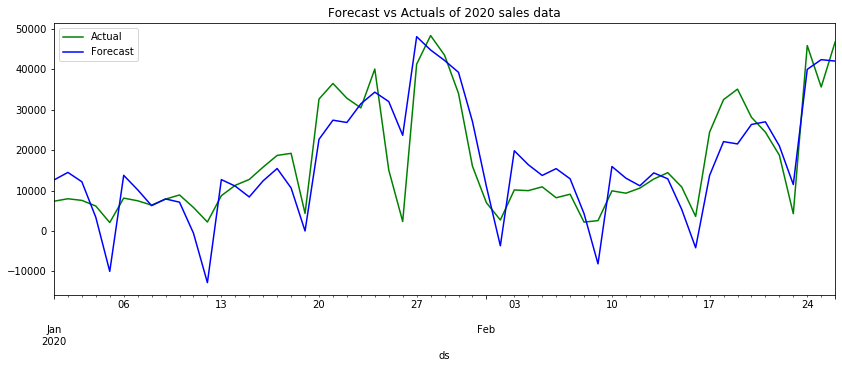

In [33]:
#visualize variations

f, ax = plt.subplots(figsize=(14,5))
temp.plot(kind='line',x='ds', y='y', color='green', label='Actual', ax=ax)
test2020.plot(kind='line',x='ds',y='yhat', color='blue',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals of 2020 sales data')
plt.show()

In [34]:
mape = m_a_p_e(temp['y'],abs(test2020['yhat']))
print('MAPE:', mape)

MAPE: 71.71704598954113


We see that by using these hyperparameters, the model's performance has been improved by a factor of almost 100% which is awesome!! The forceast also seems to follow the trend in the actual sales values for the most part. Obviously the model can be further improved upon using different hyperparameter values or combinations, or even introducing new hyperparameters. For example using **Bayesian sampling** to get uncertainty for seasonality by using the `mcmc_samples` parameter. However, this is a great improvement on the base model so I'll take it.  
We will now forecast sales for the next six months.

In [35]:
#Make prediction for the next six months

future = final_model.make_future_dataframe(periods=242, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds          yhat    yhat_lower    yhat_upper
931 2020-08-20  30164.434046  12283.183276  46868.695721
932 2020-08-21  32169.910072  13764.738259  51082.021556
933 2020-08-22  26759.007098   9254.156136  43819.106460
934 2020-08-23  16276.737061  -1627.335182  34767.300036
935 2020-08-24  43486.907776  26491.520556  61227.794346
936 2020-08-25  45679.024910  28539.802303  63444.423222
937 2020-08-26  48328.873234  30862.208053  66585.658639
938 2020-08-27  52655.494838  36666.083858  69844.874438
939 2020-08-28  50710.474440  34669.399780  67392.272542
940 2020-08-29  42988.809516  25230.944163  60760.329381

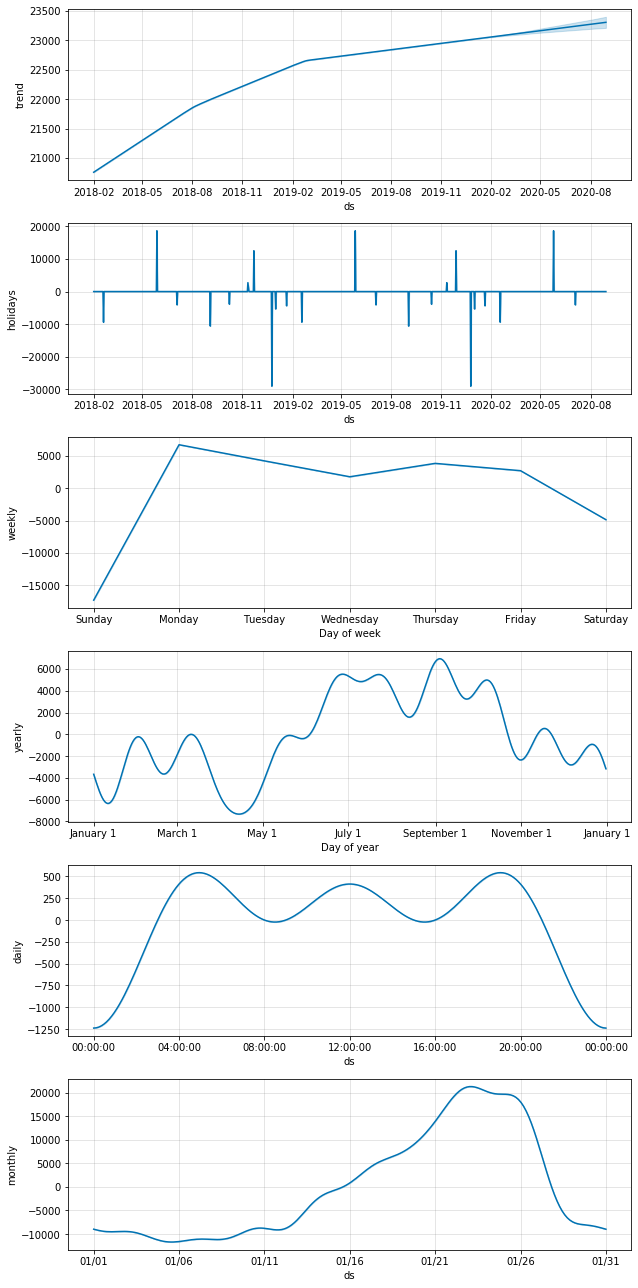

In [36]:
fig = final_model.plot_components(forecast)

In [37]:
#Plot forecast

py.iplot(plot_plotly(final_model, forecast))

Beautiful, just beautiful!! Now we are going visualize the forecasts periodically to gain a better understanding of the prophecy.

In [38]:
#Subset forecast dataframe so that we are only plotting 2020 data

temp = forecast[forecast['ds'] > end]
X, y = date_periods(temp, label='yhat')
periodic_fc = pd.concat([X, y], axis=1)
periodic_fc.head(10)

dayofweek    month  quarter  year          yhat
699  Wednesday  January        1  2020  12595.340842
700   Thursday  January        1  2020  14467.991917
701     Friday  January        1  2020  12161.313016
702   Saturday  January        1  2020   3380.799394
703     Sunday  January        1  2020  -9976.993678
704     Monday  January        1  2020  13745.109772
705    Tuesday  January        1  2020  10178.200761
706  Wednesday  January        1  2020   6261.056113
707   Thursday  January        1  2020   7914.367154
708     Friday  January        1  2020   7118.588632

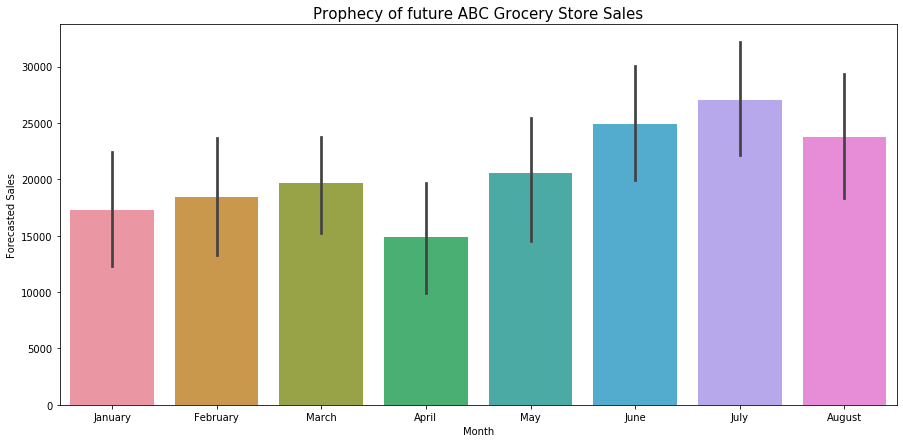

In [39]:
fig, ax = plt.subplots(figsize=(15,7))
palette = sns.color_palette("hls")
ax = sns.barplot(x="month", y="yhat",data=periodic_fc)
ax.set(xlabel='Month', ylabel='Forecasted Sales')
ax.set_title("Prophecy of future ABC Grocery Store Sales",fontsize=15)
plt.show()

In [40]:
#Observe monthly sales per year

X, y = date_periods(forecast, label='yhat')
periodic_y = pd.concat([X, y], axis=1)
periodic_y.head(10)

dayofweek     month  quarter  year          yhat
0   Thursday  February        1  2018  14616.349619
1     Friday  February        1  2018  12639.491077
2   Saturday  February        1  2018   4951.272354
3     Sunday  February        1  2018  -7796.267961
4     Monday  February        1  2018  14908.533704
5    Tuesday  February        1  2018  11428.920260
6  Wednesday  February        1  2018   9066.587126
7   Thursday  February        1  2018  11201.506341
8     Friday  February        1  2018   9714.442869
9   Saturday  February        1  2018   2730.369630

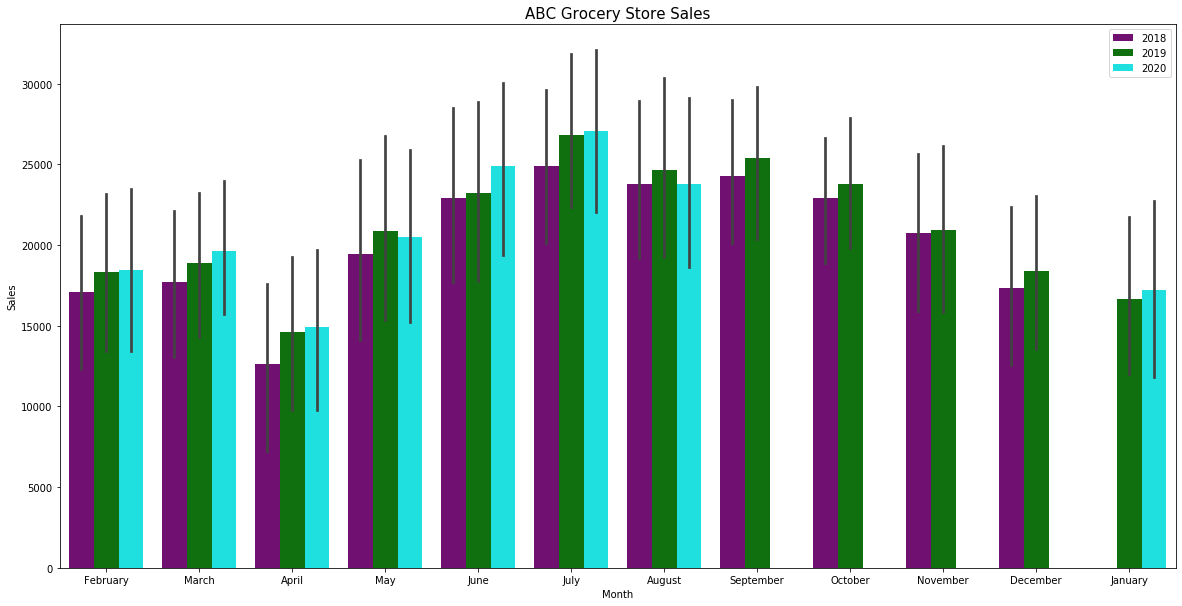

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="month", y="yhat",hue = 'year',palette = ['purple','green','cyan','black'], data=periodic_y)
ax.set(xlabel='Month', ylabel='Sales')
ax.set_title("ABC Grocery Store Sales",fontsize=15)
plt.legend(loc='upper right')
plt.show()

If ABC is happy with the sales they are getting so far, then they have nothing to worry about because over the next 6 months the store is going to experience better average monthly sales compared to the previous years for the most part. Plus considering how difficult it is to relocate, staying at this location seems to be the best business decision.